In [1]:
import sys
import warnings

warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
sys.path.append("../")

## Prepare Data

In [2]:
from traditional_models.utils import load_np

X_train, y_train = load_np("train.npy")
X_test, y_test = load_np("test.npy")

In [3]:
from traditional_models.utils import get_sample

datasets = {}
for samples_num in [5000, 10000, 15000]:
    datasets[samples_num] = get_sample(X_train, y_train, samples_num)

In order to skip intensive computation we skip parameter tuning for most architectures, however suggested values are kept for viewer to give him a chance to evaluate them on his own (just change n_iter to much higher, like 20 or something)

## Random Forest Classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier
from traditional_models.models import search_model_2

params_forest = {  
    "n_estimators": (250, 750),
    "max_depth": (3, 10),
    "min_samples_split": (2, 20),
    "min_samples_leaf": (2, 20),
    "criterion": ["gini", "entropy"]
}

results_forest = search_model_2(datasets, RandomForestClassifier(random_state=200, n_jobs=-1), params_forest, n_iter=1)

In [5]:
from traditional_models.models import report, get_best

report(results_forest, X_test, y_test)
random_forest = get_best(results_forest)[1][0]

For ds of size 5000:
	Training score: 0.8965
	Testing score:
		f1_score   - 0.8938
		accuracy_score - 0.8949
For ds of size 10000:
	Training score: 0.8955
	Testing score:
		f1_score   - 0.8939
		accuracy_score - 0.8951
For ds of size 15000:
	Training score: 0.8948
	Testing score:
		f1_score   - 0.8938
		accuracy_score - 0.8951

Best model for ds_size = 5000
Best params:
{
    "criterion": "gini",
    "max_depth": 7,
    "min_samples_leaf": 15,
    "min_samples_split": 5,
    "n_estimators": 498
}


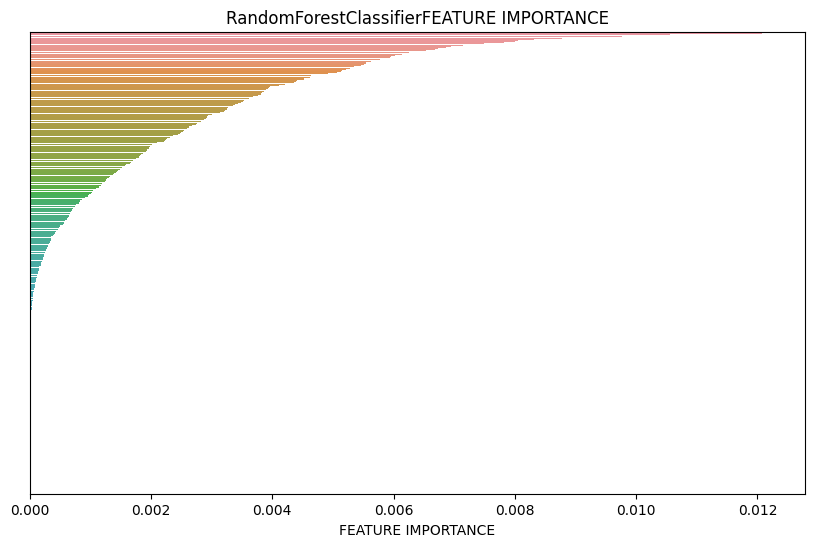

In [6]:
from traditional_models.models import plot_feature_importance

plot_feature_importance(random_forest.feature_importances_, "RandomForestClassifier")

Based on above chart let's try to drop reduntant pixels - keep only half most important ones

In [7]:
import numpy as np

importances = random_forest.feature_importances_
keep = np.argsort(-importances, )[:int(np.ceil(len(importances) / 2))]

X_reduced, y = datasets[15000]
X_reduced = X_reduced[:, keep]
random_forest_reduced = RandomForestClassifier(**random_forest.get_params())
random_forest_reduced.fit(X_reduced, y)

RandomForestClassifier(max_depth=7, min_samples_leaf=15, min_samples_split=5,
                       n_estimators=498, n_jobs=-1, random_state=200)

That allowed us to keep nearly the same accuracy and lower training time

In [8]:
from traditional_models.models import print_metrics

print_metrics(random_forest_reduced, X_test[:, keep], y_test)

f1_score   - 0.8918
accuracy_score - 0.8930


## ExtraTreesClassifier

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

params_extra = {  
    "n_estimators": (250, 750),
    "max_depth": (3, 10),
    "min_samples_split": (2, 20),
    "min_samples_leaf": (2, 20),
    "criterion": ["gini", "entropy"]
}

results_extra = search_model_2(datasets, ExtraTreesClassifier(random_state=200, n_jobs=-1), params_extra, n_iter=1)

In [10]:
report(results_extra, X_test, y_test)
extra_trees = get_best(results_extra)[1][0]

For ds of size 5000:
	Training score: 0.8968
	Testing score:
		f1_score   - 0.8912
		accuracy_score - 0.8924
For ds of size 10000:
	Training score: 0.8960
	Testing score:
		f1_score   - 0.8941
		accuracy_score - 0.8953
For ds of size 15000:
	Training score: 0.8950
	Testing score:
		f1_score   - 0.8955
		accuracy_score - 0.8968

Best model for ds_size = 5000
Best params:
{
    "criterion": "gini",
    "max_depth": 7,
    "min_samples_leaf": 15,
    "min_samples_split": 5,
    "n_estimators": 498
}


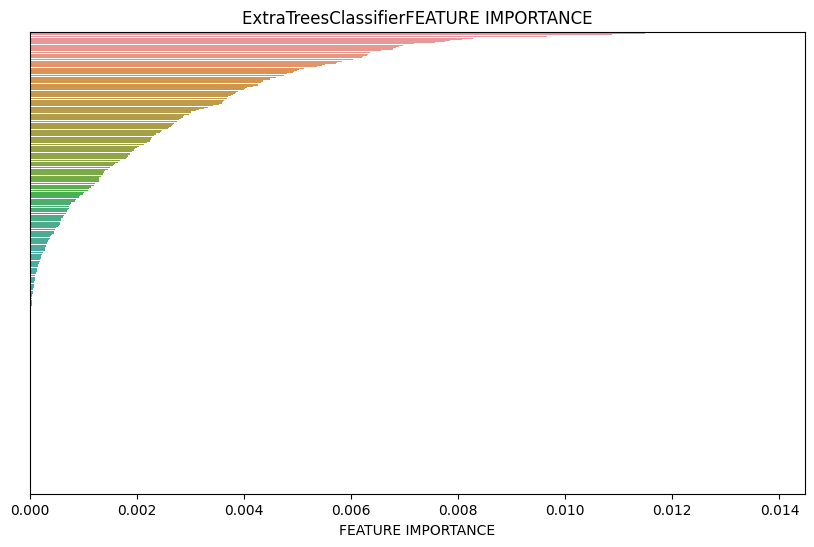

In [11]:
plot_feature_importance(extra_trees.feature_importances_, "ExtraTreesClassifier")

This time let's try to find the best model using pixels with any feature importance. This time thus to smaller pixel count we allow more estimators

In [12]:
import numpy as np

def get_no_zero_importance(best_model, datasets):
    importances = best_model.feature_importances_
    keep = np.where(importances > 0)[0]
    X_reduced, y = datasets[15000]
    X_reduced = X_reduced[:, keep]
    print(f"Kept {len(keep)} pixels out of {len(best_model.feature_importances_)}.")
    return X_reduced, y, keep

In [13]:
params_extra["n_estimators"] = (250, 1000)

X_reduced, y, keep = get_no_zero_importance(extra_trees, datasets)
results_extra_reduced = search_model_2({15000: (X_reduced, y)}, ExtraTreesClassifier(random_state=200, n_jobs=-1), params_extra, n_iter=1)

Kept 502 pixels out of 723.


In [14]:
report(results_extra_reduced, X_test[:, keep], y_test)

For ds of size 15000:
	Training score: 0.8940
	Testing score:
		f1_score   - 0.8942
		accuracy_score - 0.8954

Best model for ds_size = 15000
Best params:
{
    "criterion": "gini",
    "max_depth": 7,
    "min_samples_leaf": 15,
    "min_samples_split": 5,
    "n_estimators": 622
}


To later use let's save indexes of these "most important" pixels

In [20]:
import os

os.makedirs(f"data", exist_ok=True)
with open(os.path.join("data", "best_pixels.npy"), "wb") as f:
    np.save(f, keep)